In [1]:
import os
import re
import kelp_tools_linux as kt
import time 
import rasterio
import cupy as cp
import cudf
import numpy as np
from rasterio.errors import RasterioIOError
import matplotlib.pyplot as plt
from cuml.ensemble import RandomForestClassifier as cuRF
from cuml.model_selection import train_test_split
from scipy.stats import randint
import pickle
import csv
from cupyx.scipy.ndimage import binary_dilation, convolve
from IPython.display import clear_output
from matplotlib.colors import ListedColormap
import filing_tools as ft
from pyproj import Transformer
from matplotlib import rcParams

In [4]:
reclassify = True #Reclassify previously classified images
show_image = True
sleep = False
#classified_path = r'/mnt/c/users/attic/hls_kelp/imagery/rf_classified_cuML'
save_final_data = False
version = 1

backup_frequency = 5
tile = '11SKU'
location = 'Isla_vista_kelp_2018'
save_to_path = rf'/mnt/h/HLS_data/imagery/{location}/processed_v{version}'
endmember_path = rf'/mnt/c/Users/attic/HLS_Kelp/python_objects/EM_Dict_v{version}.pkl'
cloud_cover_threshold = .7
save_EMs = False
use_constant_EM = False
only_pairs = False
#save_mask = True
#save_classification = True
#remask = False
path = os.path.join('/mnt/c/Users/attic/HLS_Kelp/imagery/Isla_vista_kelp_2018/11SKU')#r'/mnt/h/HLS_data/imagery',location,tile) #
#H:\HLS_data\imagery\Catalina\11SLT
dem_path = r'/mnt/c/Users/attic/HLS_Kelp/imagery/Socal_DEM.tiff'
rf_model = 'cu_rf9'
rf_path = os.path.join(r'/mnt/c/users/attic/hls_kelp/random_forest',rf_model)
num_iterations = 2000

#unclassified_path = r'/mnt/c/users/attic/hls_kelp/imagery/rf_prepped_v2'
#unclassified_files = os.listdir(unclassified_path)

In [3]:
print(os.listdir(path))

['HLS.L30.T11SLT.2024204T182746.v2.0', 'HLS.L30.T11SLT.2024212T182757.v2.0', 'HLS.L30.T11SLT.2024228T182800.v2.0', 'HLS.L30.T11SLT.2024236T182805.v2.0', 'HLS.S30.T11SLT.2024183T182919.v2.0', 'HLS.S30.T11SLT.2024198T182921.v2.0', 'HLS.S30.T11SLT.2024203T182919.v2.0', 'HLS.S30.T11SLT.2024208T182921.v2.0', 'HLS.S30.T11SLT.2024213T182919.v2.0', 'HLS.S30.T11SLT.2024218T184101.v2.0', 'HLS.S30.T11SLT.2024223T182919.v2.0', 'HLS.S30.T11SLT.2024228T182921.v2.0', 'HLS.S30.T11SLT.2024233T182919.v2.0']


Starting HLS.L30.T11SKU.2018026T183403.v2.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-911..6229].


RF finished. Duration:0.9910151958465576 seconds


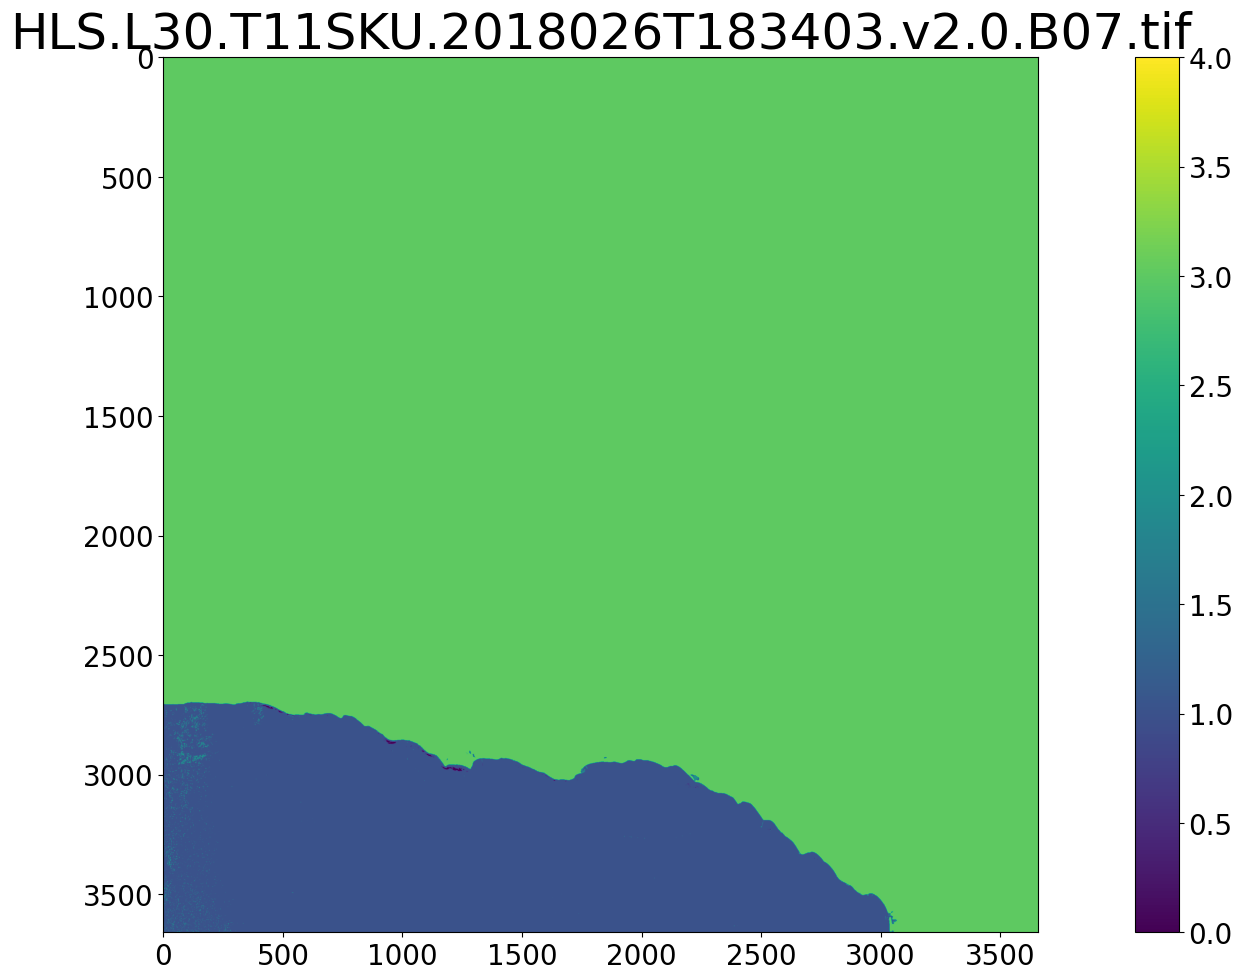

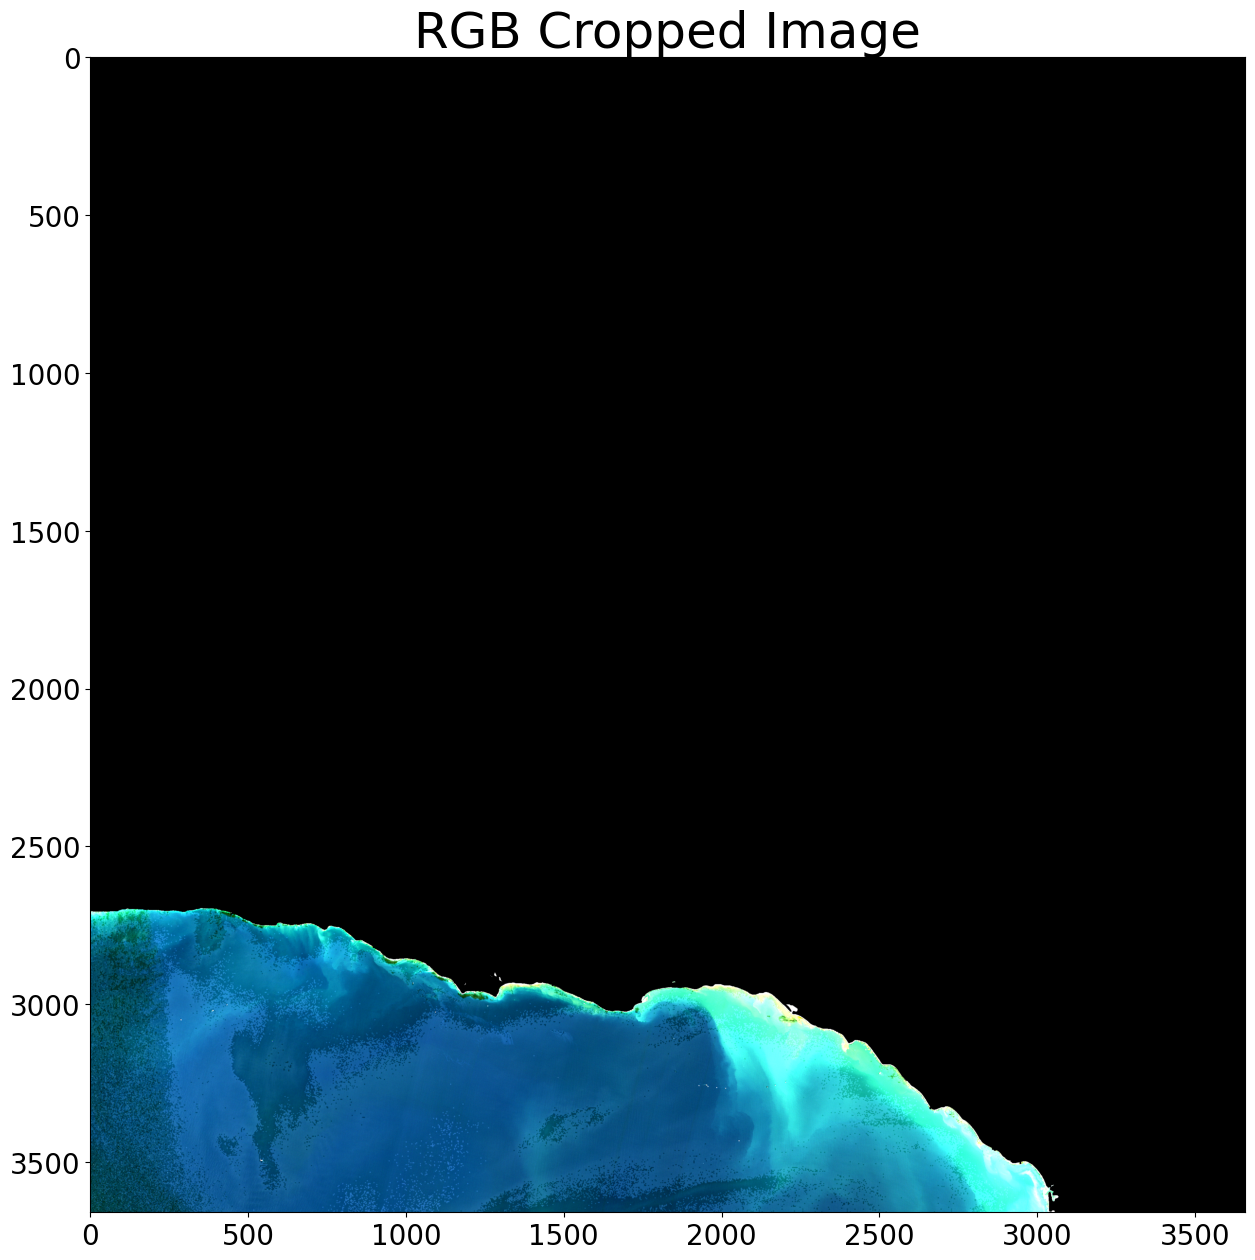

Masking finished. Duration:0.3884086608886719 seconds


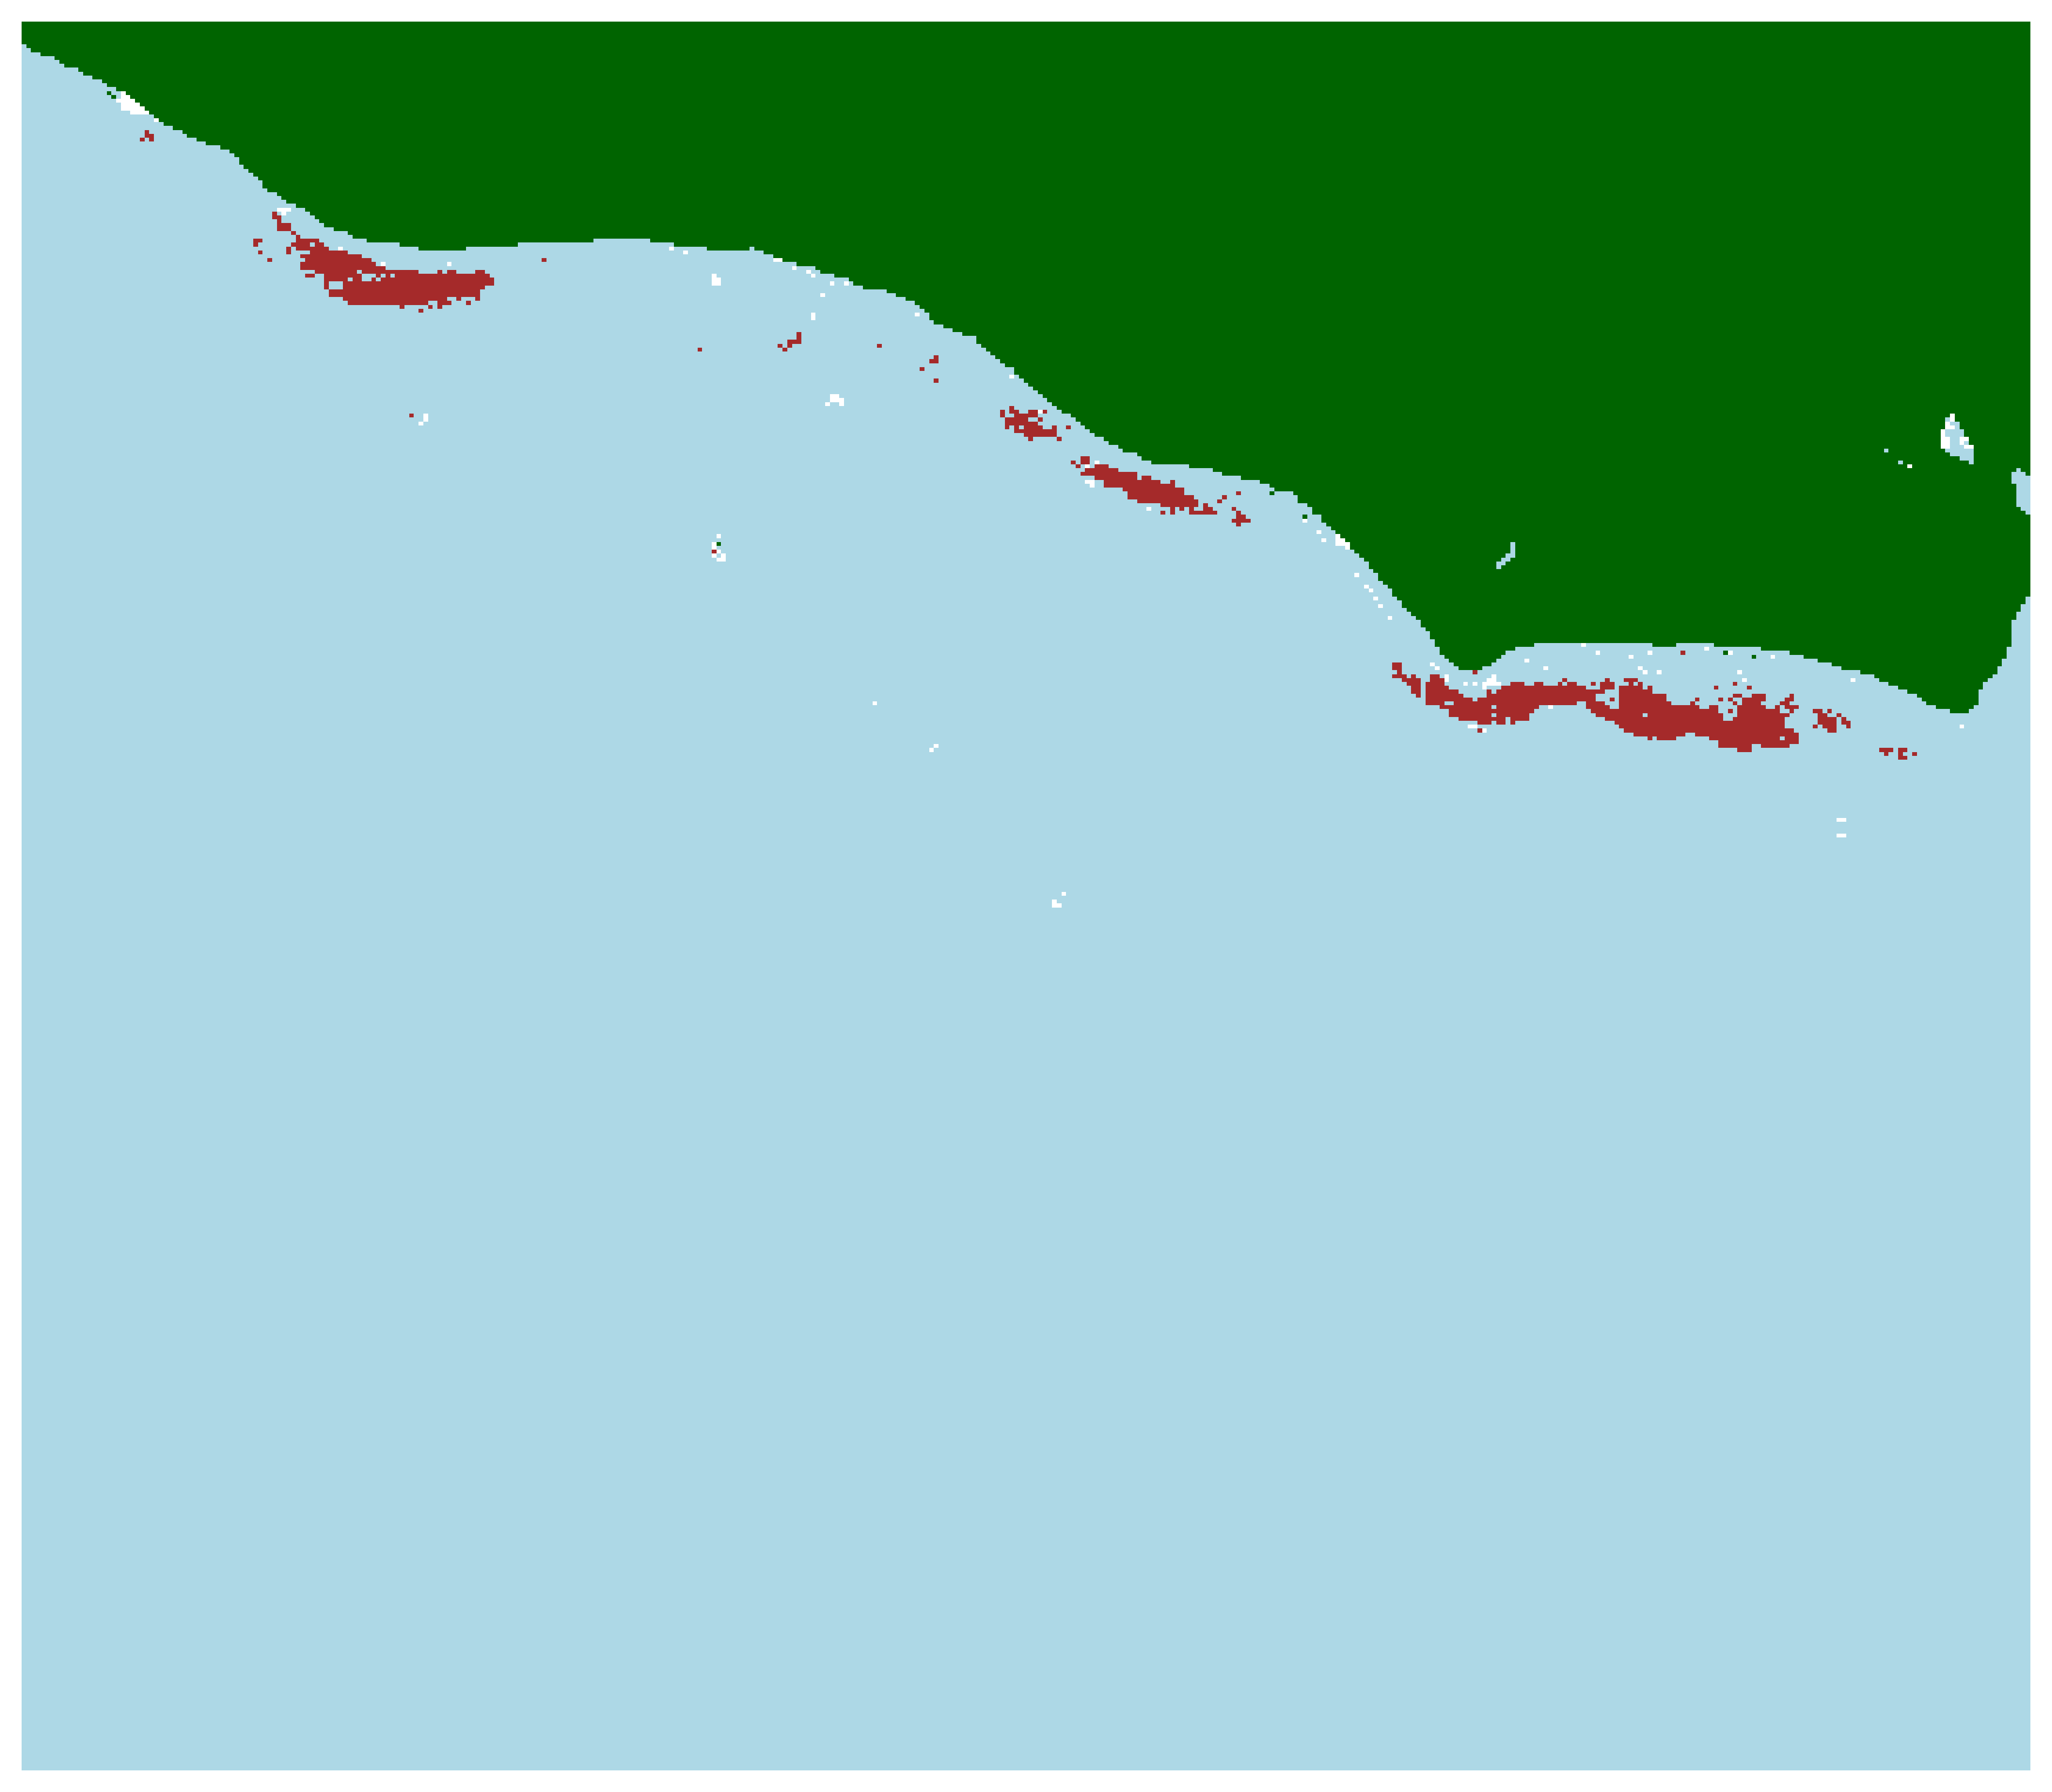

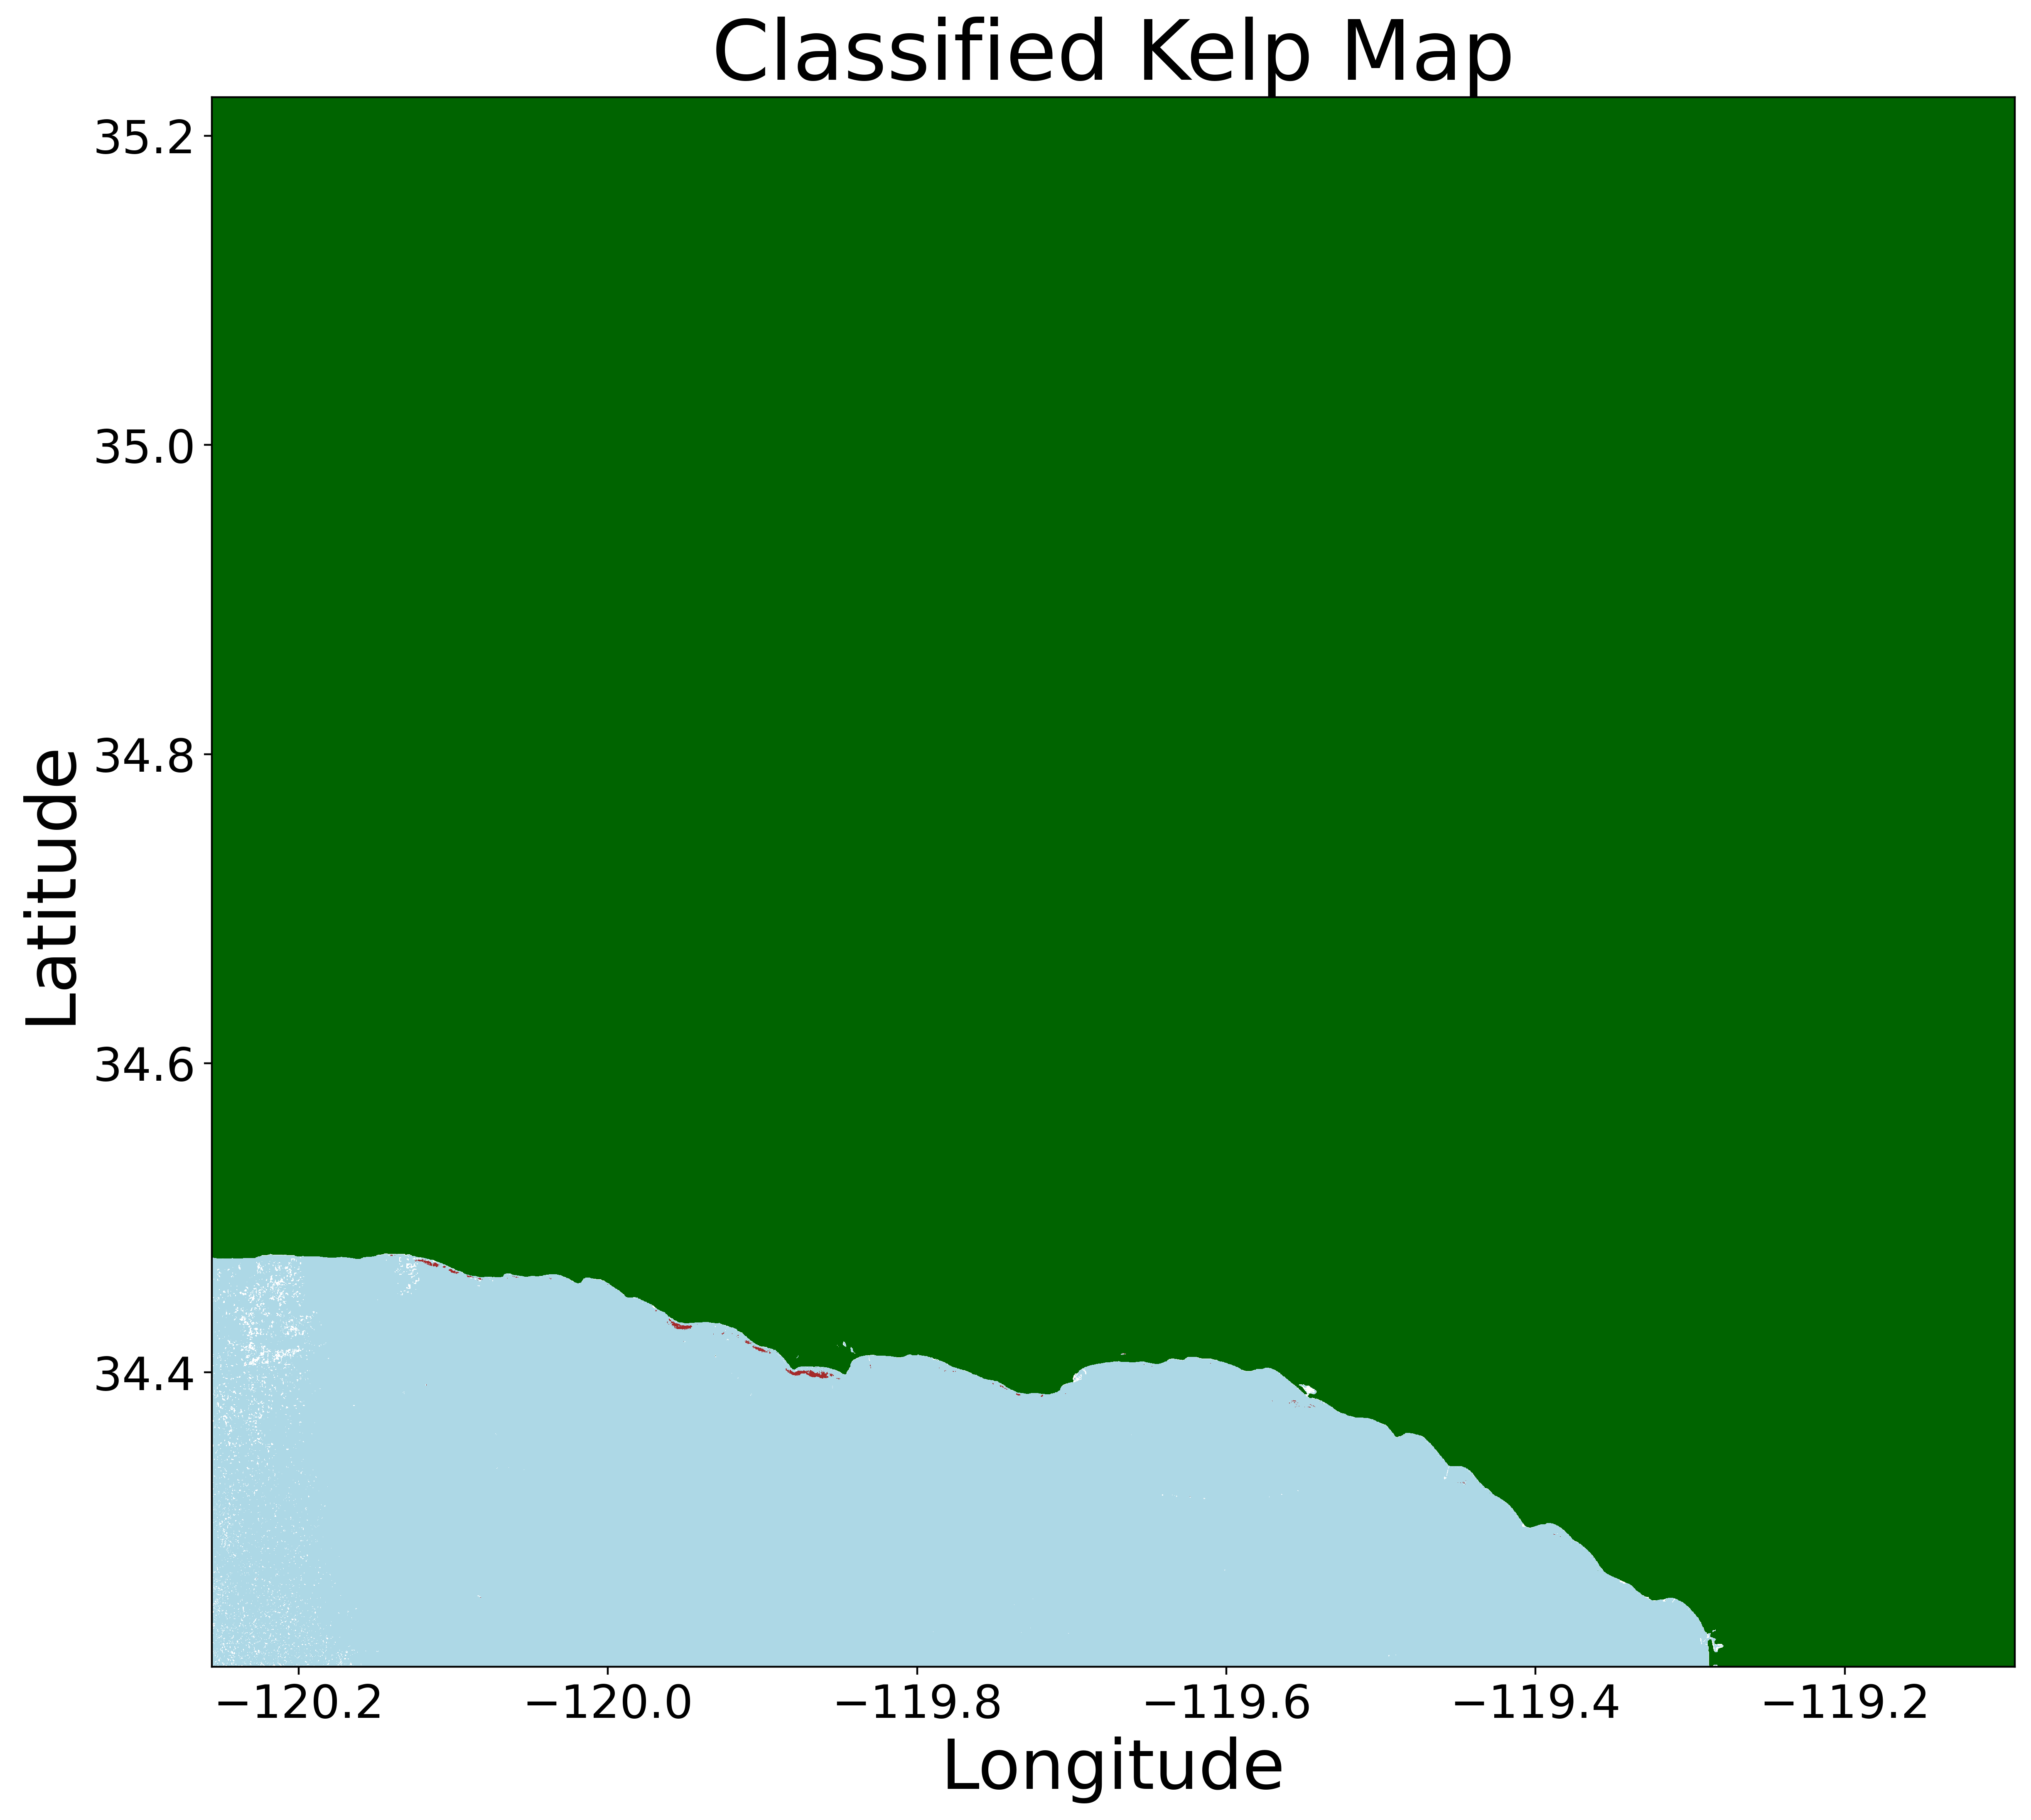

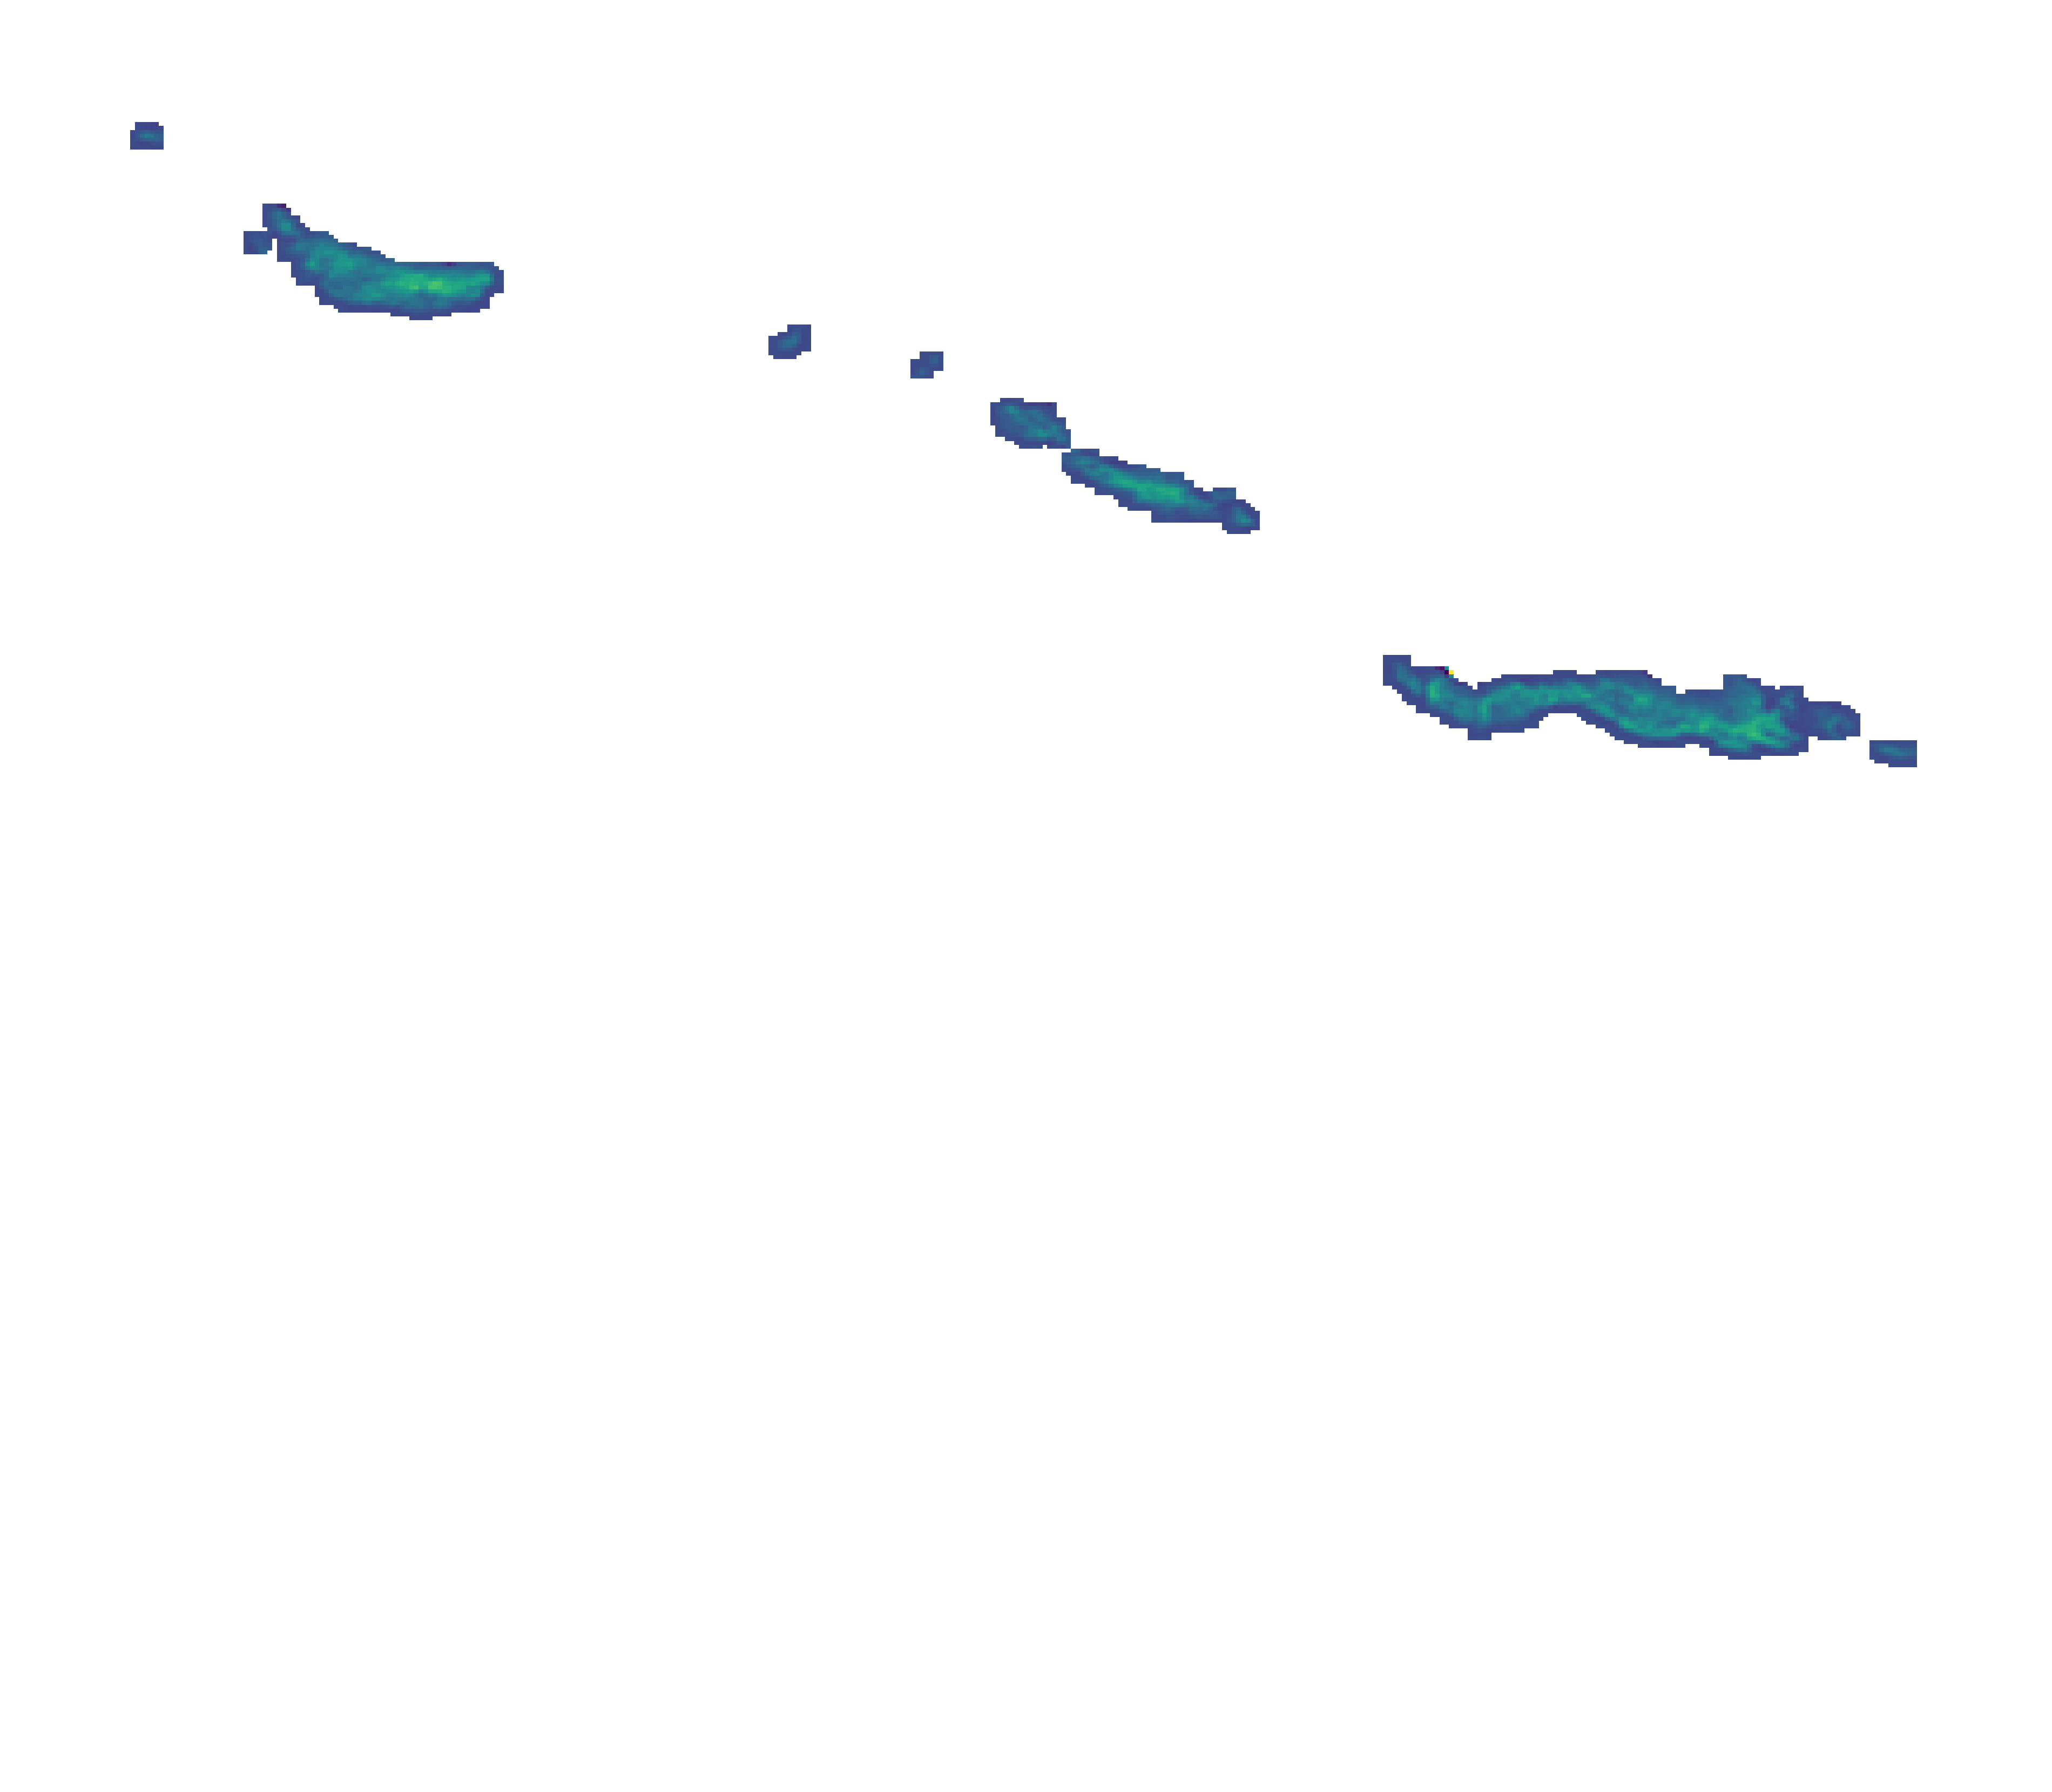

NameError: name 'rgb_cropped' is not defined

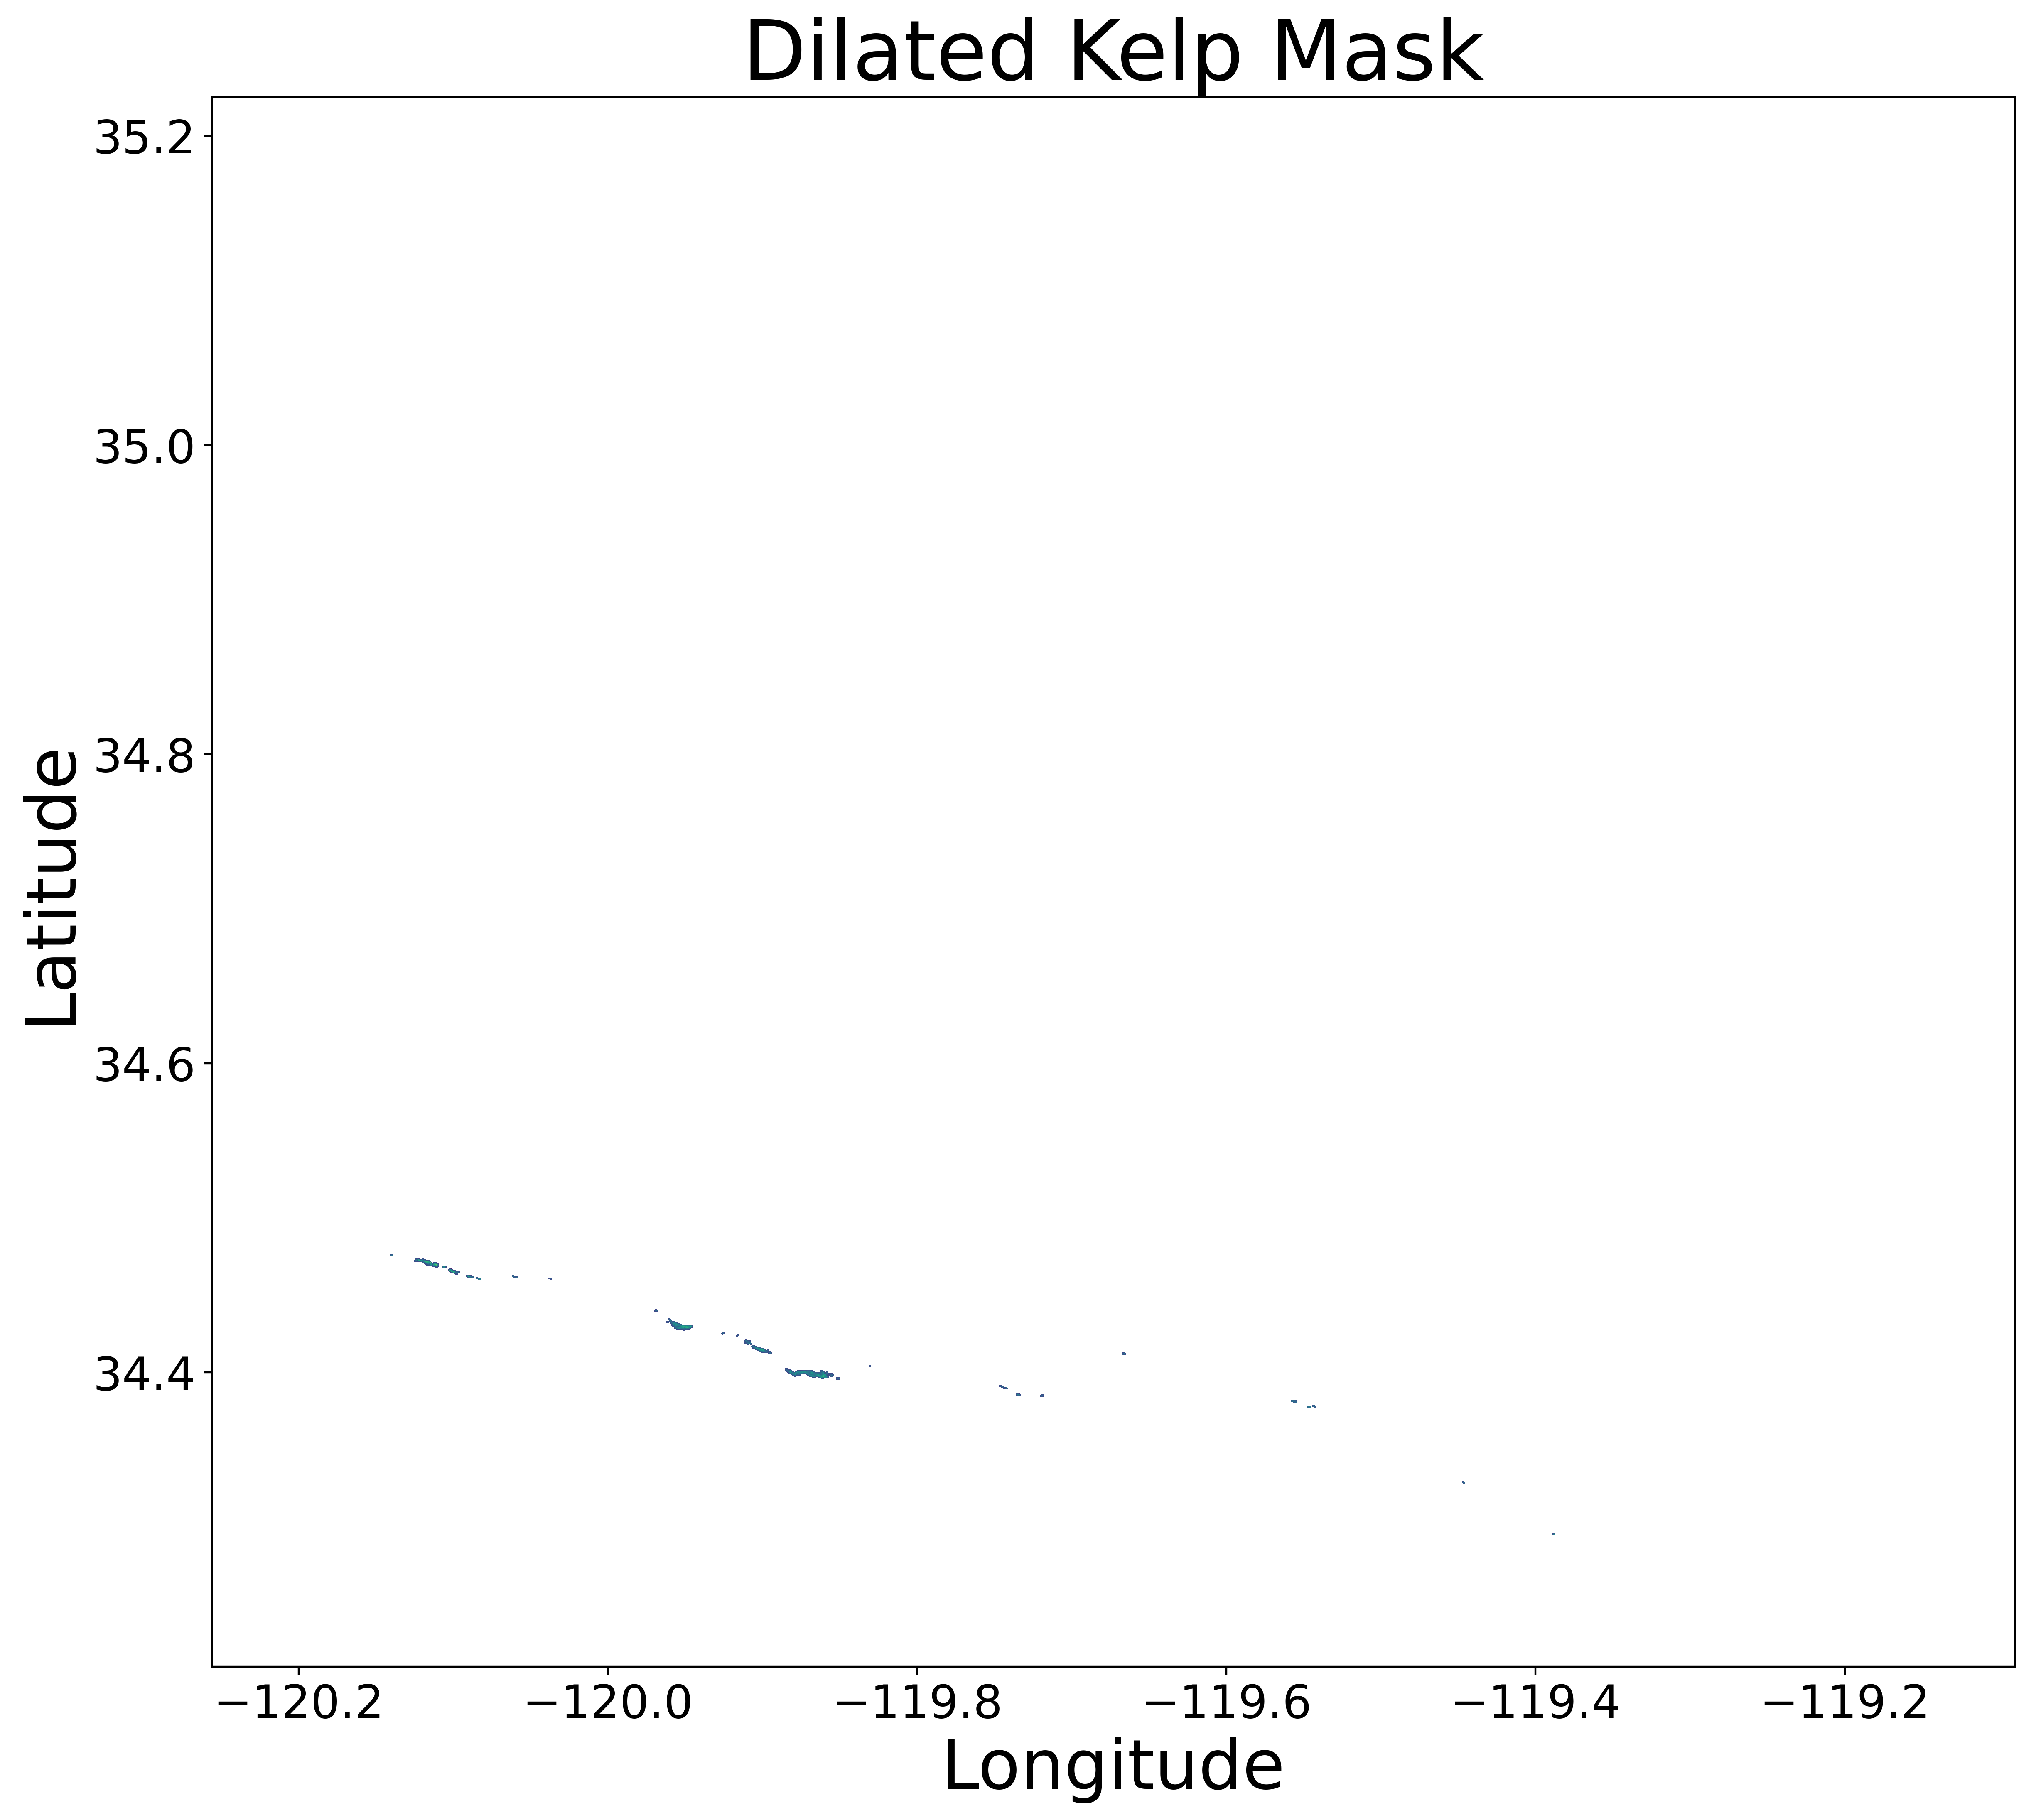

<Figure size 5600x5600 with 0 Axes>

In [7]:
if only_pairs:
    all_files  = ft.get_paired_filenames(path)
else:
    all_files = os.listdir(path)

for item in all_files:
    if os.path.isdir(os.path.join(path, item)):
        hls_path = os.path.join(path, item)
        granule = item
        break
    else:
        continue

pattern = re.compile(rf'.tif$')
files = os.listdir(os.path.join(path, item))
img_files = [f for f in files if re.search(pattern, f)]
geotiff_path = os.path.join(hls_path, img_files[0])

land_mask = kt.create_land_mask(geotiff_path, dem_path)
del files, img_files, pattern

with open(rf_path, 'rb') as f:
    cu_rf = pickle.load(f)

iterations = 0

if (save_final_data) and not os.path.isdir(save_to_path):
    os.mkdir(save_to_path)


endmember_dict = {}
for item in all_files[2:]:
    start_time = time.time()
    #print_memory_usage("Before processing granule")

    if not reclassify and os.path.isfile(os.path.join(save_to_path, tile, f'{item}_processed.tif')):
        print(f'{item} already processed. Skipping.')
        continue

    print(f'Starting {item}')
    if iterations > num_iterations:
        break

    # Define image path
    if os.path.isdir(os.path.join(path, item)):
        img_path = os.path.join(path, item)
    else:
        continue
    
    try:
        sorted_files = kt.filter_and_sort_files(img_path, item)
    except:
        print(f"{item} failed to sort filenames, skipping")
        continue

    if len(sorted_files) != 6:
        print(f'Incomplete file download: {item}')
        continue

    metadata = kt.get_metadata(img_path)

    cloud_land_mask, cloud_but_not_land_mask, percent_cloud_covered = kt.create_qa_mask(land_mask, img_path)
    if percent_cloud_covered >= cloud_cover_threshold:
        print(f'{item} Percent cloud covered: {percent_cloud_covered}')
        del cloud_land_mask, cloud_but_not_land_mask
        continue

    img_bands = []
    crs = None
    transform = None
    try:
        for file in sorted_files:
            with rasterio.open(os.path.join(img_path, file)) as src:
                img_bands.append(cp.where(cloud_land_mask, 0, cp.asarray(src.read(1))))
                if(transform is None):
                    transform = src.transform
                    crs= src.crs

        del cloud_land_mask
    except RasterioIOError as e:
        print(f"Error reading file {file} in granule {item}: {e}")
        continue 

    img = cp.stack(img_bands, axis=0)
    del img_bands
    n_bands, height, width = img.shape

    img_2D_normalized = kt.normalize_img(img, flatten=True)
    img_data = cudf.DataFrame(img_2D_normalized)

    img_data = img_data.astype(np.float32)

    pred_time = time.time()
    kelp_pred = cu_rf.predict(img_data)
    print(f'RF finished. Duration:{time.time()-pred_time} seconds')

    del img_data, img_2D_normalized

    classified_img = kelp_pred.values_host.reshape(width, height)
    classified_img = cp.where(cloud_but_not_land_mask, 2, cp.asarray(classified_img)) #

    if show_image:
        plt.figure(figsize=(25, 25)) 
        plt.subplot(2, 1, 1)  
        plt.imshow(cp.asnumpy(classified_img))
        plt.colorbar()
        plt.title(file)
        r_nor = img[2, :, :].reshape((height, width))
        g_nor = img[1, :, :].reshape((height, width))
        b_nor = img[0, :, :].reshape((height, width))
        rgb_nor_gpu = cp.stack([r_nor, g_nor, b_nor], axis=-1) 
        rgb_nor = cp.asnumpy(rgb_nor_gpu)
        rgb_cropped = cp.asnumpy(rgb_nor)#[2700:3400, 600:2000])
        plt.figure(figsize=(15,15))
        plt.imshow(rgb_cropped)
        plt.title("RGB Cropped Image")
        plt.show()
        del rgb_cropped, rgb_nor_gpu, rgb_nor

    mesma_mask_params = [
        100,      # ocean_dilation_size
        6,        # kelp_neighborhood
        3,        # min_kelp_count
        5,       # kelp_dilation_size
        15,       # variance_window_size
        0.95,      # variance_threshold
        True #Variance Mask 
    ]
    pred_time=time.time()
    kelp_mask, ocean_mask = kt.create_mesma_mask(classified_img, img, land_mask, cloud_but_not_land_mask, *mesma_mask_params)
    print(f'Masking finished. Duration:{time.time()-pred_time} seconds')
    img = cp.asnumpy(img)
    classified_img_cpu = cp.asnumpy(classified_img)
    del cloud_but_not_land_mask, classified_img
    if show_image:
        extent = kt.get_extent(transform, width, height)
        image = classified_img_cpu[2800:3250, 875:1300]
        kelp_image = kelp_mask[3,2800:3250, 875:1300]
            # Update the transform for the cropped image
        #new_transform = transform * rasterio.Affine.translation(875, 2800)
        extent_kelp = kt.get_extent(transform,3250-2800,1300-875)
        transformer = Transformer.from_crs(crs, 'EPSG:4326', always_xy=True)
        classified_img_cpu = np.where(classified_img_cpu==4, 2, classified_img_cpu)
        # Transform the extent coordinates
        # lon_min, lat_min = transformer.transform(extent_kelp[0], extent_kelp[2])
        # lon_max, lat_max = transformer.transform(extent_kelp[1], extent_kelp[3])
        lon_min, lat_min = transformer.transform(extent[0], extent[2])
        lon_max, lat_max = transformer.transform(extent[1], extent[3])
        cmap = ListedColormap(['brown','lightblue', 'white','darkgreen'])
        # Define the new extent in lat/lon
        extent_latlon = [lon_min, lon_max, lat_min, lat_max]
        x_ticks = np.linspace(lon_min, lon_max, 4)
        y_ticks = np.linspace(lat_min, lat_max, 4)
        x_tick_labels = [f'{x:.2f}' for x in x_ticks]
        y_tick_labels = [f'{y:.2f}' for y in y_ticks]
        # Plot the image with the new extent
        mesma_mask_vis = cp.stack([ocean_mask[2] / 600, ocean_mask[0] / 600, ocean_mask[1] / 600], axis=-1)

        rcParams.update({
            'font.size': 16,
            'axes.titlesize': 36,
            'axes.labelsize': 30,
            'xtick.labelsize': 20,
            'ytick.labelsize': 20
        })
        plt.figure(figsize=(12, 12), dpi=400)
        plt.imshow(image, cmap=cmap, alpha=1, extent=extent_latlon)
        plt.axis('off')
        #plt.title("Classified Kelp Map")
        plt.show()

        plt.figure(figsize=(14, 14), dpi=400)
        plt.imshow(classified_img_cpu, cmap=cmap, alpha=1, extent=extent_latlon)
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.title("Classified Kelp Map")

        # Second plot: Dilated Kelp Mask
        plt.figure(figsize=(12, 12), dpi=400)
        plt.imshow(cp.asnumpy(kelp_image), alpha=1, extent=extent_latlon, vmax=1000)
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')
        #plt.title("Dilated Kelp Mask")
        plt.show()

        plt.figure(figsize=(14, 14), dpi=400)
        plt.imshow(cp.asnumpy(kelp_mask[3]), alpha=1, extent=extent_latlon, vmax=1000)
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.title("Dilated Kelp Mask")

        # Third plot: Land-Masked Image
        plt.figure(figsize=(14, 14), dpi=400)
        plt.imshow(rgb_cropped, alpha=1, extent=extent_latlon)
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.title("Land-Masked Image")
        
        plt.figure(figsize=(12, 12), dpi=400)
        plt.imshow(rgb_cropped[2800:3250, 875:1300], cmap=cmap, alpha=1, extent=extent_latlon)
        plt.axis('off')
        #plt.title("Classified Kelp Map")
        plt.show()


        del mesma_mask_vis, image
    if use_constant_EM:
        ocean_EM = [
            [213., 202., 208., 201., 193., 198., 142., 158., 192., 105., 192., 120., 136., 168., 128., 179., 200., 178., 170., 196., 152., 144., 181., 158., 163., 190., 190., 194., 205., 143.],
            [139., 130., 107., 129., 147., 118., 119., 113., 111.,  75., 103., 105., 120., 123., 121.,  99., 126., 136.,  79., 141., 104., 113., 108., 115., 115., 135., 142., 115., 110., 121.],
            [ 35.,  42.,  38.,  41.,  11.,  30.,  16.,  38.,  33.,  20.,  29.,  33.,   8.,  43.,  18.,  25.,  46.,  10.,  23.,  36.,  18.,  27.,   8.,  28.,  31.,  33.,  46.,  39.,  18.,  33.],
            [  2.,  -6.,  -5.,  -8.,  -3., -10.,   0.,  -1., -10.,  -8.,   3.,  -6., -13., -14.,  -3.,  -6.,  -4.,  -8., -12., -16.,   1.,  -8., -13.,   1.,  -4.,   0.,  -3., -15.,  -5., -11.]
        ]
    else:
        ocean_EM = kt.select_ocean_endmembers(ocean_mask=ocean_mask, print_average=False)
        if ocean_EM is None:
            continue

    pred_time = time.time()
    mesma, minVals = kt.run_mesma(kelp_mask, ocean_EM, print_status=False)
    print(f'MESMA finished. Duration:{time.time()-pred_time} seconds')
    if(save_EMs):
        endmember_dict[item] = cp.asnumpy(ocean_EM)
    del ocean_EM, ocean_mask
    min_vals = cp.asnumpy(minVals)
    del minVals
    mesma_array = cp.asnumpy(mesma)
    del mesma

    if show_image:
        kelp_img = cp.asnumpy(kelp_mask).astype(np.float32)
        Mes_array_vis = np.where(mesma_array <5 , np.nan, mesma_array)
        #Mes_array_vis = np.where(Mes_array_vis >70 , np.nan, Mes_array_vis)
        kelp_vis = np.where(kelp_img == 0, np.nan, kelp_img)
        plt.figure(figsize=(12, 12), dpi=400)
        plt.imshow(kelp_img[1], cmap='Greys', alpha=1, extent=extent_latlon, vmax=600) #,2800:3250, 875:1300]
        plt.imshow(Mes_array_vis, alpha=1, extent=extent_latlon )#, vmax=80) #[2800:3250, 875:1300]
        cbar = plt.colorbar( shrink=.75)
        cbar.ax.tick_params(labelsize=16)  # Set the font size for colorbar ticks
        cbar.set_label('Kelp Endmember Number Multiple', fontsize=20)
        plt.xlabel('Longitude', fontsize=30)
        plt.ylabel('Latitude', fontsize=30)
        #plt.axis('off')
        plt.title("MESMA Output", fontsize=36)
        plt.xticks([],fontsize=16)
        plt.yticks([],fontsize=16)
        plt.show()
        del kelp_mask

    if save_final_data:
        num_bands = 7
        data_type = rasterio.int16
        profile = {
            'driver': 'GTiff',
            'width': width,
            'height': height,
            'count': num_bands,  # one band  B02, B03, B04, and B05, classified, mesma (Blue, Green, Red, and NIR).
            'dtype': data_type,  # assuming binary mask, adjust dtype if needed
            'crs': src.crs,
            'transform': src.transform,
            'nodata': 0,  # assuming no data is 0
            'tags': {'TIMESTAMP': metadata['SENSING_TIME'], 'CLOUD_COVERAGE': percent_cloud_covered, 'RF_MODEL': rf_model, 'VIS_LINK': metadata['data_vis_url']}
        }
        if not os.path.isdir(os.path.join(save_to_path, tile)):
            os.mkdir(os.path.join(save_to_path, tile))
        img_path = os.path.join(save_to_path, tile, f'{item}_processed.tif')

        # Write the land mask array to geotiff
        with rasterio.open(img_path, 'w', **profile) as dst:
            dst.write(img[0].astype(data_type), 1)
            dst.write(img[1].astype(data_type), 2)
            dst.write(img[2].astype(data_type), 3)
            dst.write(img[3].astype(data_type), 4)
            dst.write(classified_img_cpu.astype(data_type), 5)
            dst.write(mesma_array.astype(data_type), 6)
            dst.write(min_vals.astype(np.float16), 7)
            dst.update_tags(TIMESTAMP=metadata['SENSING_TIME'], CLOUD_COVERAGE=percent_cloud_covered, RF_MODEL=rf_model, VIS_LINK=metadata['data_vis_url'])

    iterations += 1
        # 
    print(f"File complete: {item} | Iteration: {iterations} | Time: {time.time() - start_time}")

    del img, classified_img_cpu, mesma_array, min_vals
    cp.get_default_memory_pool().free_all_blocks()
    cp.get_default_pinned_memory_pool().free_all_blocks()
    
    if save_EMs and iterations % backup_frequency == 0:
        if os.path.isfile(endmember_path):
            with open(endmember_path, 'rb') as f:
                endmember_log = pickle.load(f)
        else:
            endmember_log = []
        endmember_log.append(endmember_dict)
        
        with open(endmember_path, 'wb') as f:
            pickle.dump(endmember_log, f)
        endmember_dict = {}
        print(f'Endmembers Logged on iteration: {iterations}')


    if sleep and iterations % 30 == 0 and iterations != 0:
        print("Cooling down GPU...")
        time.sleep(240)
        clear_output(wait=True)  
            
    if os.path.isfile(endmember_path):
        with open(endmember_path, 'rb') as f:
            endmember_log = pickle.load(f)
    else:
        endmember_log = []
    endmember_log.append(endmember_dict)

    with open(endmember_path, 'wb') as f:
        pickle.dump(endmember_log, f)

In [5]:
if os.path.isfile(endmember_path):
    with open(endmember_path, 'rb') as f:
        endmember_log = pickle.load(f)
else:
    endmember_log = []
endmember_log.append(endmember_dict)

with open(endmember_path, 'wb') as f:
    pickle.dump(endmember_log, f)